In [1]:
from diskcache import Cache
import os
from Utils.data_manager import DataManager
from Utils.models import CIFAR_Net
from Clients.training import Training
import copy
import torch
from torch import nn
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class FULDebug:
    def __init__(self, cache, breakpoint, num_parties, num_fl_rounds):
        
        cache["breakpoint"] = breakpoint
        self.num_parties = num_parties
        self.num_fl_rounds = num_fl_rounds
        self.cache = cache
    
    def average_selected_models(self, selected_parties, party_models):
        with torch.no_grad():
            sum_vec = nn.utils.parameters_to_vector(party_models[selected_parties[0]].parameters())
            if len(selected_parties) > 1:
                for i in range(1,len(selected_parties)):
                    sum_vec += nn.utils.parameters_to_vector(party_models[selected_parties[i]].parameters())
                sum_vec /= len(selected_parties)

            model = copy.deepcopy(party_models[0])
            nn.utils.vector_to_parameters(sum_vec, model.parameters())
        return model.state_dict()
    
    def aggregate(self, client_models, current_model=None):
        selected_parties = [i for i in range(self.num_parties)]
        aggregated_model_state_dict = self.average_selected_models(selected_parties, client_models)
        return aggregated_model_state_dict 
    
    def partiesStart(self, trainloader_lst, testloader, client_to_be_erased=100):

        num_fl_rounds = self.num_fl_rounds
        num_parties = self.num_parties
        initial_model = CIFAR_Net()
        model_dict = copy.deepcopy(initial_model.state_dict())
        client_models_all_rounds = []
        global_models_all_rounds = []
        for round_num in range(num_fl_rounds): 
            ##################### Local Training Round #############################
            current_model_state_dict = copy.deepcopy(model_dict)
            current_model = copy.deepcopy(initial_model)
            current_model.load_state_dict(current_model_state_dict)
            client_models = []
            party_losses = []
            for party_id in range(num_parties):

                if party_id == client_to_be_erased:
                    client_models.append(CIFAR_Net())
                else:
                    model = copy.deepcopy(current_model)
                    local_training = Training(num_updates_in_epoch=None, num_local_epochs=5)
                    model_update, party_loss = local_training.train(model=model, 
                                                trainloader=trainloader_lst[party_id], 
                                                criterion=None, opt=None, dataType="CIFAR")

                    client_models.append(copy.deepcopy(model_update))
                    party_losses.append(party_loss)
                    print(f"Party {party_id} Loss: {party_loss}")
            ######################################################################  
            current_model_state_dict = self.aggregate(client_models=client_models, current_model=current_model)
            model_dict = copy.deepcopy(current_model_state_dict)
            eval_model = CIFAR_Net()
            eval_model.load_state_dict(current_model_state_dict)
            clean_acc = local_training.evaluate(testloader, eval_model)
            client_models_all_rounds.append(copy.deepcopy(client_models))
            global_models_all_rounds.append(copy.deepcopy(current_model_state_dict))
            # clean_accuracy[fusion_key][round_num] = clean_acc        
            self.cache[f"client_models"] = client_models
            self.cache[f"global_models"] = current_model_state_dict
            print(f'Global Clean Accuracy, round {round_num} = {clean_acc}')
            # print(self.cache.get(f"client_models_{round_num}"))
        self.cache["client_models_all_rounds"] = client_models_all_rounds
        self.cache["global_models_all_rounds"] = global_models_all_rounds

    # Function to compute class-wise accuracy
    def compute_classwise_metrics(self, model, test_loader):
        class_correct = defaultdict(int)
        class_total = defaultdict(int)
        
        model.eval()
        
        with torch.no_grad():
            for data, labels in test_loader:
                if data.dim() == 5:  # If the image has an extra dimension, squeeze it
                    data = data.squeeze(1)  # Remove the extra dimension
                    
                # Check if the input tensor has the correct shape for CIFAR-10
                if data.shape[1] == 32:  # Indicates the channel dimension is incorrectly set as 32
                    # Permute from [batch_size, height, width, channels] to [batch_size, channels, height, width]
                    data = data.permute(0, 3, 1, 2)
                    
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                
                # Update class-wise correct/total counts
                for label, prediction in zip(labels, predicted):
                    class_total[label.item()] += 1
                    if label.item() == prediction.item():
                        class_correct[label.item()] += 1
        
        # Compute class-wise accuracies
        class_accuracies = {cls: class_correct[cls] / class_total[cls] if class_total[cls] > 0 else 0
                            for cls in class_total}
        
        return class_accuracies, class_total

    # Function to identify classes impacted by unlearning
    def identify_affected_classes(self, global_model_before, global_model_after, test_loader, threshold=0.05):
        """
        Identify the classes that are significantly impacted after unlearning client 0.
        
        :param global_model_before: The global model before unlearning.
        :param global_model_after: The global model after unlearning.
        :param test_loader: The test data loader.
        :param threshold: The threshold to consider a class significantly impacted.
        :return: A list of impacted classes.
        """
        # Compute class-wise accuracy before and after unlearning
        before_class_accuracies, _ = self.compute_classwise_metrics(global_model_before, test_loader)
        after_class_accuracies, _ = self.compute_classwise_metrics(global_model_after, test_loader)
    
        impacted_classes = []
    
        # Compare class accuracies before and after unlearning
        for cls in before_class_accuracies:
            accuracy_drop = before_class_accuracies[cls] - after_class_accuracies[cls]
            if accuracy_drop > threshold:
                impacted_classes.append(cls)
    
        return impacted_classes

    def calculate_class_weights(self, global_model_before, global_model_after, test_loader, impacted_classes):
        """
        Calculate class weights based on the accuracy difference before and after unlearning.
        
        :param global_model_before: Global model before unlearning.
        :param global_model_after: Global model after unlearning.
        :param test_loader: DataLoader for the test data.
        :param impacted_classes: List of impacted classes.
        :return: Dictionary with class indices as keys and weights as values.
        """
        # Compute class-wise accuracies before and after unlearning
        class_accuracies_before, _ = self.compute_classwise_metrics(global_model_before, test_loader)
        class_accuracies_after, _ = self.compute_classwise_metrics(global_model_after, test_loader)
        
        # Calculate the absolute difference in accuracy for each impacted class
        accuracy_diffs = {class_idx: abs(class_accuracies_before[class_idx] - class_accuracies_after[class_idx])
                          for class_idx in impacted_classes}
        
        # Normalize the differences to sum to 1 (to be used as weights)
        total_diff = sum(accuracy_diffs.values())
        class_weights = {class_idx: (diff / total_diff) for class_idx, diff in accuracy_diffs.items()} if total_diff > 0 else {class_idx: 1/len(impacted_classes) for class_idx in impacted_classes}
        
        # Print class weights for reference
        for class_idx, weight in class_weights.items():
            print(f"Class {class_idx} Weight: {weight:.4f}")
        
        return class_weights

    
    def select_clients_to_fix_bias(self, clients_models, impacted_classes, test_loader, global_model, global_model_before, global_model_after, num_clients=3, lambda_penalty=0.1):
        """
        Select clients that contribute the most to the affected classes with automated class weighting and regularization.
        
        :param clients_models: List of models for remaining clients.
        :param impacted_classes: List of classes impacted by unlearning client 0.
        :param test_loader: DataLoader for the test data.
        :param global_model: Global model to compute deviations for regularization.
        :param global_model_before: Global model before unlearning.
        :param global_model_after: Global model after unlearning.
        :param num_clients: Number of clients to select for fixing the bias.
        :param lambda_penalty: Regularization term to penalize clients with large deviations from global performance.
        :return: Tuple of (list of selected client indices, list of selected client models).
        """
        # Automatically assign class weights based on accuracy impact
        class_weights = self.calculate_class_weights(global_model_before, global_model_after, test_loader, impacted_classes)
    
        client_contributions = []
        
        # Compute global model's class-wise accuracy for regularization
        global_class_accuracies, _ = self.compute_classwise_metrics(global_model, test_loader)
        
        # Compute class-wise accuracy for each client
        for client_idx, client_model in enumerate(clients_models):
            class_accuracies, _ = self.compute_classwise_metrics(client_model, test_loader)
            
            # Calculate the weighted contribution of this client to the impacted classes
            contribution = sum((class_accuracies[class_idx] * class_weights[class_idx]) for class_idx in impacted_classes)
            
            # Compute the regularization term: deviation from the global model
            deviation_penalty = sum(abs(class_accuracies[class_idx] - global_class_accuracies[class_idx]) for class_idx in impacted_classes)
            
            # Final score: contribution minus regularization penalty
            final_contribution = contribution - lambda_penalty * deviation_penalty
            
            client_contributions.append((client_idx, client_model, final_contribution))
        
        # Sort clients by their final contribution score
        client_contributions.sort(key=lambda x: x[2], reverse=True)
        
        # Select top clients to fix the bias
        selected_clients = client_contributions[:num_clients]
        
        # Extract client indices and models for the selected clients
        selected_client_indices = [client_idx for client_idx, _, _ in selected_clients]
        selected_client_models = [client_model for _, client_model, _ in selected_clients]
        
        # Print selected clients and their contributions
        for client_idx, _, contribution in selected_clients:
            print(f"Selected Client {client_idx} with Contribution: {contribution:.4f}")
        
        # Return both selected client indices and models
        return selected_client_models, selected_client_indices


    def unlearnedModelAggregationWithSelectedClients(self, trainloader_lst, testloader, unlearned_model, num_rounds=10, client_to_be_erased=100, select_clients_method='random', select_num_clients=6):
    
        num_parties = self.num_parties
        initial_model = CIFAR_Net()
        current_model_state_dict = copy.deepcopy(unlearned_model.state_dict())  
        initial_model.load_state_dict(current_model_state_dict)  
        model_dict = copy.deepcopy(initial_model.state_dict())

        model_before = self.cache.get('initial_model')
        model_before.load_state_dict(self.cache.get('global_models'))
        model_before.eval()
        
        model_after = self.cache.get('initial_model')
        model_after.load_state_dict(self.cache.get("unlearned_model").state_dict())
        model_after.eval()
        
        client_model = self.cache.get('initial_model')
        client_model.load_state_dict(self.cache.get("client_models")[0].state_dict())
        client_model.eval()
        
        global_model_accuracies = []
        for round_num in range(num_rounds): 
            ##################### Local Training Round #############################
            current_model_state_dict = copy.deepcopy(model_dict)
            current_model = copy.deepcopy(initial_model)
            current_model.load_state_dict(current_model_state_dict)
            client_models = []
            party_losses = []
    
            for party_id in range(num_parties):
                if party_id == client_to_be_erased:
                    client_models.append(CIFAR_Net())  # Placeholder for unlearned client
                else:
                    model = copy.deepcopy(current_model)
                    local_training = Training(num_updates_in_epoch=None, num_local_epochs=2)
                    model_update, party_loss = local_training.train(model=model, 
                                                    trainloader=trainloader_lst[party_id], 
                                                    criterion=None, opt=None, dataType="CIFAR")
    
                    client_models.append(copy.deepcopy(model_update))
                    party_losses.append(party_loss)
                    print(f"Party {party_id} Loss: {party_loss}")
    
            ###################### Client Selection ###############################
            impacted_classes = self.identify_affected_classes(model_before, model_after, testDataloader, threshold=0.05)
            selected_client_models, selected_client_indices = self.select_clients_to_fix_bias(client_models, impacted_classes, testDataloader, model_before, model_before, model_after, num_clients=5)
            print(selected_client_models)
    
            #######################################################################
            # Aggregate only the selected client models
            current_model_state_dict = self.unlearnAggregate(client_models=selected_client_models, client_to_be_erased=client_to_be_erased)
            model_dict = copy.deepcopy(current_model_state_dict)
            eval_model = CIFAR_Net()
            eval_model.load_state_dict(current_model_state_dict)
    
            clean_acc = local_training.evaluate(testloader, eval_model)
            print(f'Global Clean Accuracy, round {round_num} = {clean_acc}')
            global_model_accuracies.append(clean_acc)
            self.cache[f"unlearning_client_models_with_FULDebug"] = client_models
            self.cache[f"unlearning_global_models_with_FULDebug"] = current_model_state_dict
            model_after = self.cache.get('initial_model')
            model_after.load_state_dict(current_model_state_dict)
            model_after.eval()
        return global_model_accuracies
    
    def unlearnAggregate(self, client_models, client_to_be_erased):
        selected_parties = [i for i in range(len(client_models))]
        aggregated_model_state_dict = self.average_selected_models(selected_parties, client_models)
        return aggregated_model_state_dict
    
    def unlearnedModelAggregation(self, trainloader_lst, testloader, unlearned_model, num_rounds=10, client_to_be_erased=100):

        num_parties = self.num_parties
        initial_model = CIFAR_Net()
        current_model_state_dict = copy.deepcopy(unlearned_model.state_dict())  
        initial_model.load_state_dict(current_model_state_dict)  
        model_dict = copy.deepcopy(initial_model.state_dict())
        global_model_accuracies = []
        for round_num in range(num_rounds): 
            ##################### Local Training Round #############################
            current_model_state_dict = copy.deepcopy(model_dict)
            current_model = copy.deepcopy(initial_model)
            current_model.load_state_dict(current_model_state_dict)
            client_models = []
            party_losses = []
            for party_id in range(num_parties):

                if party_id == client_to_be_erased:
                    client_models.append(CIFAR_Net())
                else:
                    model = copy.deepcopy(current_model)
                    local_training = Training(num_updates_in_epoch=None, num_local_epochs=1)
                    model_update, party_loss = local_training.train(model=model, 
                                                trainloader=trainloader_lst[party_id], 
                                                criterion=None, opt=None, dataType="CIFAR")

                    client_models.append(copy.deepcopy(model_update))
                    party_losses.append(party_loss)
                    print(f"Party {party_id} Loss: {party_loss}")
            ######################################################################  
            current_model_state_dict = self.unlearnAggregate(client_models=client_models, client_to_be_erased=client_to_be_erased)
            model_dict = copy.deepcopy(current_model_state_dict)
            eval_model = CIFAR_Net()
            eval_model.load_state_dict(current_model_state_dict)
            clean_acc = local_training.evaluate(testloader, eval_model)
            # clean_accuracy[fusion_key][round_num] = clean_acc      
            self.cache[f"unlearning_client_models"] = client_models
            self.cache[f"unlearning_global_models"] = current_model_state_dict
            print(f'Global Clean Accuracy, round {round_num} = {clean_acc}')
            global_model_accuracies.append(clean_acc)
        
        return global_model_accuracies

    def compute_weight_contribution(self, global_model, client_updates, selected_client_idx):
        """
        Compute the influence of each client's weight contribution to the global model.

        :param global_model: The baseline global model (PyTorch model)
        :param client_updates: List of model updates from each client (list of state_dicts)
        :param selected_client_idx: Index of the client whose contribution you want to analyze
        :return: Difference between the global model's weights with and without the selected client's contribution
        """
        # Compute the average weight update with all clients
        num_clients = len(client_updates)
        avg_update = {key: torch.zeros_like(val) for key, val in client_updates[0].state_dict().items()}

        for update in client_updates:
            for key in update.state_dict():
                avg_update[key] += update.state_dict()[key] / num_clients

        # Compute the average weight update without the selected client
        avg_update_without_client = {key: torch.zeros_like(val) for key, val in client_updates[0].state_dict().items()}

        for i, update in enumerate(client_updates):
            if i == selected_client_idx:
                continue  # Skip the selected client
            for key in update.state_dict():
                avg_update_without_client[key] += update.state_dict()[key] / (num_clients - 1)

        # Calculate the difference in the global model's weights
        weight_difference = {key: avg_update[key] - avg_update_without_client[key] for key in avg_update}

        return weight_difference

    def compute_weight_norm_difference(self, weight_difference):
        """
        Computes the norm of the weight differences to quantify the impact.

        :param weight_difference: Dictionary containing weight differences for each layer
        :return: Dictionary with norms for each layer
        """
        norm_diff = {}
        for layer, diff in weight_difference.items():
            norm_diff[layer] = torch.norm(diff).item()
        return norm_diff
    
    def analyze_class_bias(self, global_model, weight_difference, num_classes=10):
        """
        Analyzes the class-specific impact of removing a client's weight contribution.

        :param global_model: The baseline global model (PyTorch model)
        :param weight_difference: Difference in weights with and without the selected client's contribution
        :param num_classes: Number of classes in the dataset (e.g., 10 for MNIST)
        :return: Impact on each class based on output layer weight differences
        """
        output_layer_key = None

        # Identify the output layer by checking for the appropriate layer name
        for key in weight_difference.keys():
            if 'weight' in key and weight_difference[key].shape[0] == num_classes:
                output_layer_key = key
                break

        if output_layer_key is None:
            raise ValueError("Could not identify the output layer in the model.")

        # Analyze the impact on each class
        class_impact = torch.norm(weight_difference[output_layer_key], dim=1).tolist()
        return class_impact


    def compute_gradient_norm(self, eval_model, data_loader, class_label):
        
        # eval_model = CIFAR_Net()
        # eval_model.load_state_dict(model_state_dict)
        criterion = nn.CrossEntropyLoss()
        total_grad_norm = 0
        num_batches = 0

        for data, labels in data_loader:
            print(labels)
            if class_label is not None:
                # Filter data by class label
                mask = (labels == class_label)
                data = data[mask]
                labels = labels[mask]

            if len(labels) == 0:
                continue

            
            data, labels = data.to(device), labels.to(device)
            outputs = eval_model(data)
            loss = criterion(outputs, labels)

            # Compute gradients
            eval_model.zero_grad()
            loss.backward()

            # Calculate norm of gradients
            grad_norm = 0
            for param in eval_model.parameters():
                grad_norm += torch.norm(param.grad).item()
            
            total_grad_norm += grad_norm
            num_batches += 1

        return total_grad_norm / num_batches if num_batches > 0 else 0


    def summarize_and_print_results(slef, norm_diff, class_impact):
        """
        Summarizes and prints the results of the weight differences and class impacts.

        :param norm_diff: Dictionary containing the norms of weight differences for each layer
        :param class_impact: List containing the impact on each class
        """
        print("=== Summary of Weight Differences by Layer ===")
        print(f"{'Layer':<20} {'Norm Difference':>20}")
        print("-" * 40)
        
        for layer, norm in norm_diff.items():
            print(f"{layer:<20} {norm:>20.6f}")
        
        print("\n=== Impact on Each Class ===")
        print(f"{'Class':<10} {'Impact':>10}")
        print("-" * 25)
        
        for class_idx, impact in enumerate(class_impact):
            print(f"Class {class_idx:<5} {impact:>10.6f}")
        
        print("\n=== Analysis ===")
        
        # Find the class with the maximum and minimum impact
        max_impact_class = max(range(len(class_impact)), key=lambda i: class_impact[i])
        min_impact_class = min(range(len(class_impact)), key=lambda i: class_impact[i])
        
        print(f"The highest impact is on Class {max_impact_class} with an impact value of {class_impact[max_impact_class]:.6f}.")
        print(f"The lowest impact is on Class {min_impact_class} with an impact value of {class_impact[min_impact_class]:.6f}.")

        # Determine which layers are most and least affected
        most_affected_layer = max(norm_diff, key=norm_diff.get)
        least_affected_layer = min(norm_diff, key=norm_diff.get)
        
        print(f"The most affected layer is '{most_affected_layer}' with a norm difference of {norm_diff[most_affected_layer]:.6f}.")
        print(f"The least affected layer is '{least_affected_layer}' with a norm difference of {norm_diff[least_affected_layer]:.6f}.")
        print("\nThis analysis suggests that removing the selected client's contribution mainly affects the above class and layer.")

In [2]:
# Initialize the cache
cache = Cache('./cache-cifar-10', size_limit=50 * 10**9)
initial_model = CIFAR_Net()
cache["initial_model"] = initial_model
breakpoint =  {"round": 5, "status": False}
# Initialize the MNIST loader
loader = DataManager(download_dir="./data", normalize=True)
# Load the MNIST data
(x_train, y_train), (x_test, y_test) = loader.load_cifar10()
# dataLoader = loader.split_data_uneven(x_train, y_train)
# dataLoader = loader.split_data_label_flipping(x_train, y_train)
dataLoader = loader.split_data_extreme_minority_two(x_train, y_train, minority_classes=[1, 7], concentration=0.6)
testDataloader = loader.get_test_dataloader(x_test, y_test)
print(testDataloader)

In [41]:
parties = 10
sim = FULDebug(cache, breakpoint, parties, 20)
sim.partiesStart(dataLoader, testDataloader)

Party 0 Loss: 8.742328928995736
Party 1 Loss: 11.085096935008435
Party 2 Loss: 11.072287042090233
Party 3 Loss: 10.417197711765766
Party 4 Loss: 10.44851329550147
Party 5 Loss: 10.437336631119251
Party 6 Loss: 10.398282621055841
Party 7 Loss: 10.380414381623268
Party 8 Loss: 10.427109692245722
Party 9 Loss: 10.415585730224848
Global Clean Accuracy, round 0 = 21.5
Party 0 Loss: 7.387826245796831
Party 1 Loss: 9.62216106374213
Party 2 Loss: 9.612202428756877
Party 3 Loss: 9.002404626458883
Party 4 Loss: 9.034298166632652
Party 5 Loss: 8.888452742248774
Party 6 Loss: 8.762539215385914
Party 7 Loss: 8.875818438827991
Party 8 Loss: 8.95594148337841
Party 9 Loss: 8.89375640079379
Global Clean Accuracy, round 1 = 29.26
Party 0 Loss: 6.37619664171074
Party 1 Loss: 8.316511078083769
Party 2 Loss: 8.327378879202174
Party 3 Loss: 7.932534966617823
Party 4 Loss: 7.957131702452898
Party 5 Loss: 7.939721308648586
Party 6 Loss: 7.8743452951312065
Party 7 Loss: 7.901178937405348
Party 8 Loss: 7.879135

In [44]:
from Ful_Algo.federaser import FedEraser
%load_ext autoreload
%autoreload 2
# Usage example
unlearning_instance = FedEraser(
    client_models=cache.get("client_models"),
    global_model=cache.get("global_models"),
    num_parties=parties,  # Example value
    party_to_be_erased=0,  # Example value
    trainloader_lst=dataLoader,
    testloader=testDataloader,
    testloader_poison=dataLoader,
    initial_model=FMNIST_Net(),
    selected_CMs=cache.get("client_models_all_rounds"),
    selected_GMs=cache.get("global_models_all_rounds"),
    unlearn_global_models=cache.get("global_models_all_rounds"),
    lr=0.01,
    global_epoch=9
)

unlearned_model = unlearning_instance.execute_unlearning()
cache["unlearned_model"] = unlearned_model[-1]
unlearned_model = unlearned_model[-1]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mean distance of Reference Model to random: 1690.304443359375
Radius for model_ref: 563.434814453125
------------ 0
Distance from the unlearned model to party to be erased: 13.730687141418457
Distance from the unlearned model to party to be erased: 13.82276439666748
Distance from the unlearned model to party to be erased: 13.976198196411133
Clean Accuracy for UN-Local Model = 56.5


In [57]:
sim = FULDebug(cache, breakpoint, parties, 10)
sim.unlearnedModelAggregation(dataLoader, testDataloader, unlearned_model, num_rounds=5, client_to_be_erased=0)

Party 1 Loss: 0.4817191368721901
Party 2 Loss: 0.45202078908047777
Party 3 Loss: 0.4873040299862623
Party 4 Loss: 0.492965841665864
Party 5 Loss: 0.46369110653176904
Party 6 Loss: 0.43641529278829694
Party 7 Loss: 0.4741619974374771
Party 8 Loss: 0.4399089692160487
Party 9 Loss: 0.4537842236459255
Global Clean Accuracy, round 0 = 61.62
Party 1 Loss: 0.5056909062760941
Party 2 Loss: 0.5182669917319683
Party 3 Loss: 0.42034199461340904
Party 4 Loss: 0.44760029669851065
Party 5 Loss: 0.3746642302721739
Party 6 Loss: 0.4515957199037075
Party 7 Loss: 0.4030563635751605
Party 8 Loss: 0.39097581524401903
Party 9 Loss: 0.38761955266818404
Global Clean Accuracy, round 1 = 61.64
Party 1 Loss: 0.5877834279486474
Party 2 Loss: 0.6029114685160049
Party 3 Loss: 0.5120477518066764
Party 4 Loss: 0.49904890079051256
Party 5 Loss: 0.4900211514905095
Party 6 Loss: 0.5477456599473953
Party 7 Loss: 0.4805012308061123
Party 8 Loss: 0.5226029520854354
Party 9 Loss: 0.5164125356823206
Global Clean Accuracy, r

[61.62, 61.64, 60.08, 58.97, 57.65]

In [ ]:
sim = FULDebug(cache, breakpoint, parties, 10)
global_model_accuracies_with_FULDebug = sim.unlearnedModelAggregationWithSelectedClients(dataLoader, testDataloader, unlearned_model, num_rounds=4, client_to_be_erased=0)

Party 1 Loss: 0.6091749577763232
Party 2 Loss: 0.6382238552608388
Party 3 Loss: 0.640888940077275
Party 4 Loss: 0.6684346331749111
Party 5 Loss: 0.6246578558348119
Party 6 Loss: 0.6276692412793636
Party 7 Loss: 0.6162277215626091
Party 8 Loss: 0.6344283653888851
Party 9 Loss: 0.6018454192671925
Class 3 Weight: 0.0429
Class 8 Weight: 0.0672
Class 0 Weight: 0.1766
Class 6 Weight: 0.1683
Class 9 Weight: 0.2161
Class 5 Weight: 0.1773
Class 2 Weight: 0.1517
Selected Client 3 with Contribution: 0.7145
Selected Client 9 with Contribution: 0.6979
Selected Client 7 with Contribution: 0.6814
Selected Client 8 with Contribution: 0.6799
Selected Client 5 with Contribution: 0.6776
[CIFAR_Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [8]:
%load_ext autoreload
%autoreload 2
from Utils.analytics import Analytics
analytics = Analytics(cache)
analytics.client_vs_global_per_class_accuracy(0, testDataloader)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
### Client {client_idx} vs Global Model Per Class Accuracy ###
Client Model Accuracy = 11.43%, Global Model Before Accuracy = 27.36%
Class 0: Client Model Accuracy = 8.70%, Global Model Before Accuracy = 49.60%
Class 1: Client Model Accuracy = 100.00%, Global Model Before Accuracy = 0.00%
Class 2: Client Model Accuracy = 0.00%, Global Model Before Accuracy = 1.10%
Class 3: Client Model Accuracy = 2.00%, Global Model Before Accuracy = 7.40%
Class 4: Client Model Accuracy = 0.00%, Global Model Before Accuracy = 0.20%
Class 5: Client Model Accuracy = 0.90%, Global Model Before Accuracy = 37.10%
Class 6: Client Model Accuracy = 2.70%, Global Model Before Accuracy = 62.00%
Class 7: Client Model Accuracy = 0.00%, Global Model Before Accuracy = 15.40%
Class 8: Client Model Accuracy = 0.00%, Global Model Before Accuracy = 58.40%
Class 9: Client Model Accuracy = 0.00%, Global Model Before Accuracy = 42.40%
#

In [9]:
analytics.unlearned_model_vs_global_per_class_accuracy(testDataloader)

### Unlearned vs Global Model Per Class Accuracy ###
Unlearned Model Accuracy = 25.71%, Global Model Before Accuracy = 27.36%
Class 0: Global Model Before = 49.60%, After = 61.80%, Δ = 12.20%
Class 1: Global Model Before = 0.00%, After = 0.00%, Δ = 0.00%
Class 2: Global Model Before = 1.10%, After = 1.60%, Δ = 0.50%
Class 3: Global Model Before = 7.40%, After = 13.80%, Δ = 6.40%
Class 4: Global Model Before = 0.20%, After = 1.70%, Δ = 1.50%
Class 5: Global Model Before = 37.10%, After = 34.40%, Δ = -2.70%
Class 6: Global Model Before = 62.00%, After = 49.70%, Δ = -12.30%
Class 7: Global Model Before = 15.40%, After = 17.20%, Δ = 1.80%
Class 8: Global Model Before = 58.40%, After = 41.40%, Δ = -17.00%
Class 9: Global Model Before = 42.40%, After = 35.50%, Δ = -6.90%
######


In [10]:
analytics.global_before_vs_global_after_per_class_accuracy(testDataloader)


### Unlearned vs Global Model Per Class Accuracy ###
Global Model After Accuracy = 33.88%, Global Model Before Accuracy = 27.36%
Class 0: Global Model Before = 49.60%, After = 33.60%, Δ = -16.00%
Class 1: Global Model Before = 0.00%, After = 0.00%, Δ = 0.00%
Class 2: Global Model Before = 1.10%, After = 1.10%, Δ = 0.00%
Class 3: Global Model Before = 7.40%, After = 22.80%, Δ = 15.40%
Class 4: Global Model Before = 0.20%, After = 20.80%, Δ = 20.60%
Class 5: Global Model Before = 37.10%, After = 32.80%, Δ = -4.30%
Class 6: Global Model Before = 62.00%, After = 65.80%, Δ = 3.80%
Class 7: Global Model Before = 15.40%, After = 28.70%, Δ = 13.30%
Class 8: Global Model Before = 58.40%, After = 68.20%, Δ = 9.80%
Class 9: Global Model Before = 42.40%, After = 65.00%, Δ = 22.60%
######


In [12]:
analytics.display_classwise_metrics(0, testDataloader)


Class 0:
  Accuracy:
    Client Model:      |||--------------------------- (0.09)
    Global Before:     |||||||||||||||--------------- (0.50)
    Global After:      ||||||||||-------------------- (0.34)
  Confidence:
    Client Model:      ||||-------------------------- (0.12)
    Global Before:     |||||||||--------------------- (0.29)
    Global After:      ||||||||---------------------- (0.27)
---

Class 1:
  Accuracy:
    Client Model:      |||||||||||||||||||||||||||||| (1.00)
    Global Before:     ------------------------------ (0.00)
    Global After:      ------------------------------ (0.00)
  Confidence:
    Client Model:      ||||||||||||||||||||||-------- (0.73)
    Global Before:     |----------------------------- (0.04)
    Global After:      ------------------------------ (0.00)
    Significant accuracy drop for Class 1 after unlearning compared to the client model.
    Significant confidence drop for Class 1 after unlearning compared to the client model.
---

Class 2

In [14]:
analytics.display_client_contributions_to_calss_compared_to_others(0, testDataloader, num_classes=10)


Class 0:
  Client 0 Model Accuracy:          |||--------------------------- (0.09) with 1000 samples
  Remaining Clients Model Accuracy: |||||||||||||||||------------- (0.56) with 1000 samples
  Global Model Accuracy:            |||||||||||||||--------------- (0.50) with 1000 samples

Class 1:
  Client 0 Model Accuracy:          |||||||||||||||||||||||||||||| (1.00) with 1000 samples
  Remaining Clients Model Accuracy: ------------------------------ (0.00) with 1000 samples
  Global Model Accuracy:            ------------------------------ (0.00) with 1000 samples

Class 2:
  Client 0 Model Accuracy:          ------------------------------ (0.00) with 1000 samples
  Remaining Clients Model Accuracy: ------------------------------ (0.01) with 1000 samples
  Global Model Accuracy:            ------------------------------ (0.01) with 1000 samples

Class 3:
  Client 0 Model Accuracy:          |----------------------------- (0.02) with 1000 samples
  Remaining Clients Model Accuracy: |||-

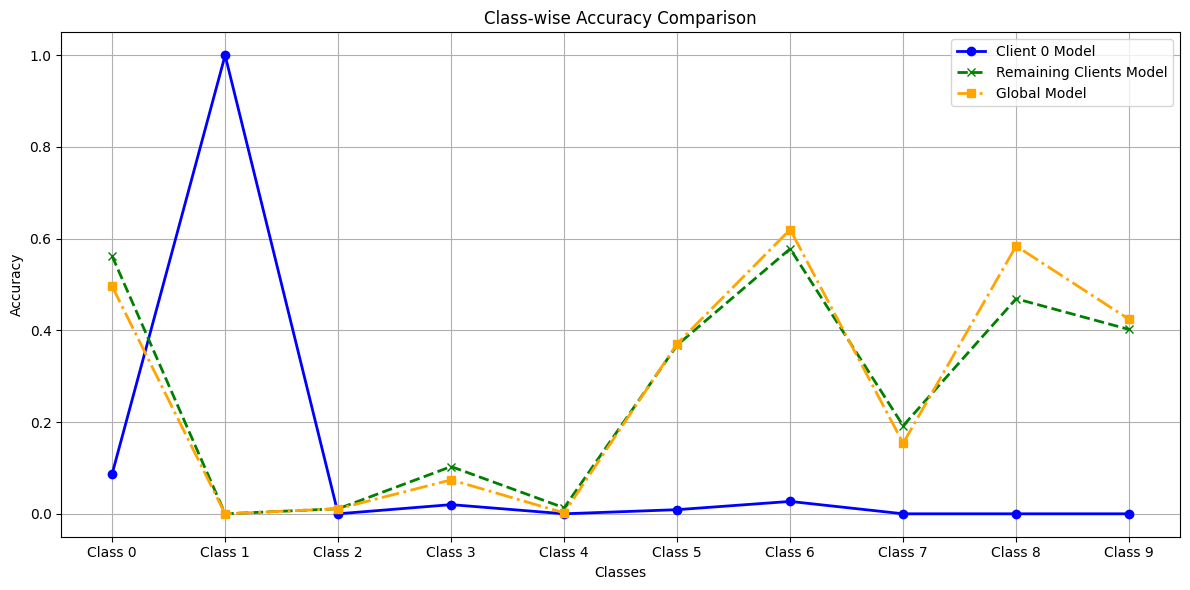

In [15]:
analytics.plot_client_contributions_to_calss_compared_to_others(0, testDataloader, num_classes=10)

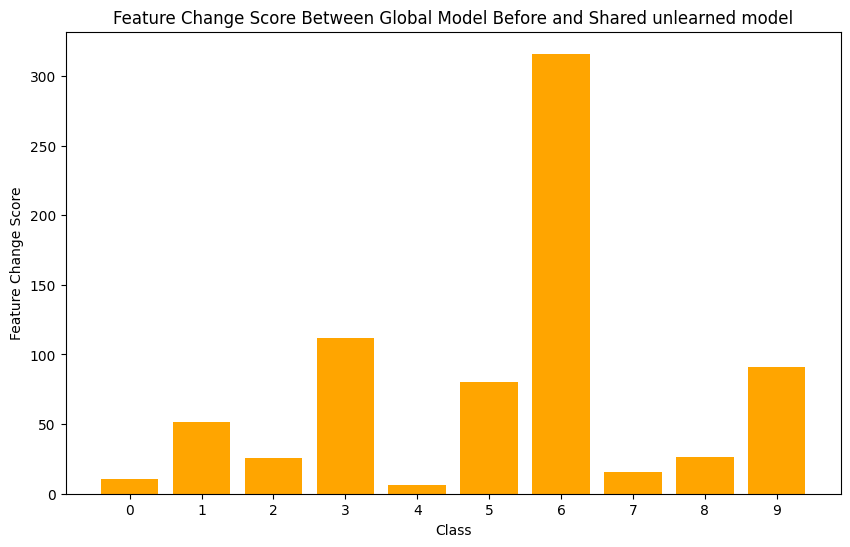

In [16]:
analytics.visualize_feature_change_class_wise_shared_unlearned_model(client_idx=0, testDataloader=testDataloader)

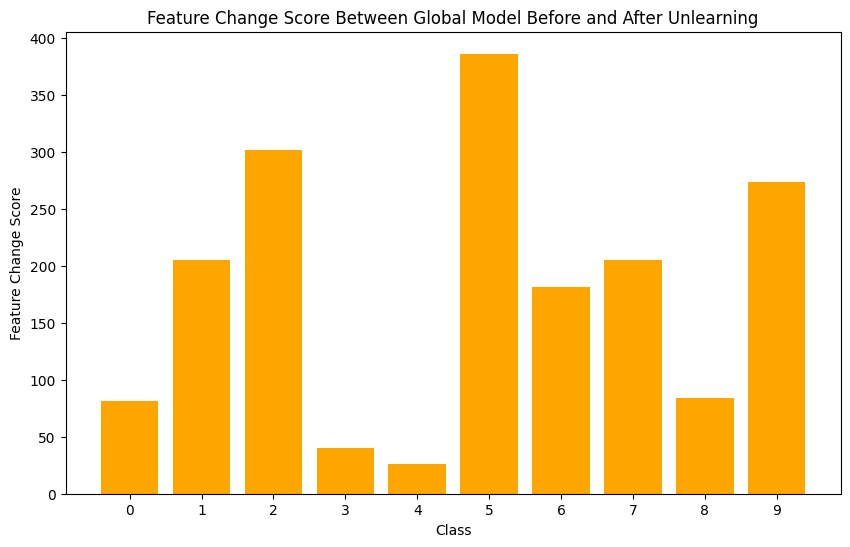

In [17]:
analytics.visualize_feature_change_class_wise(client_idx=0, testDataloader=testDataloader)

Global Model Before Unlearning Accuracy: 66.63%
Unlearned Model Accuracy: 52.17%
Unlearned Model Accuracy with FulDebug: 61.65%
Client Model Accuracy: 66.87%


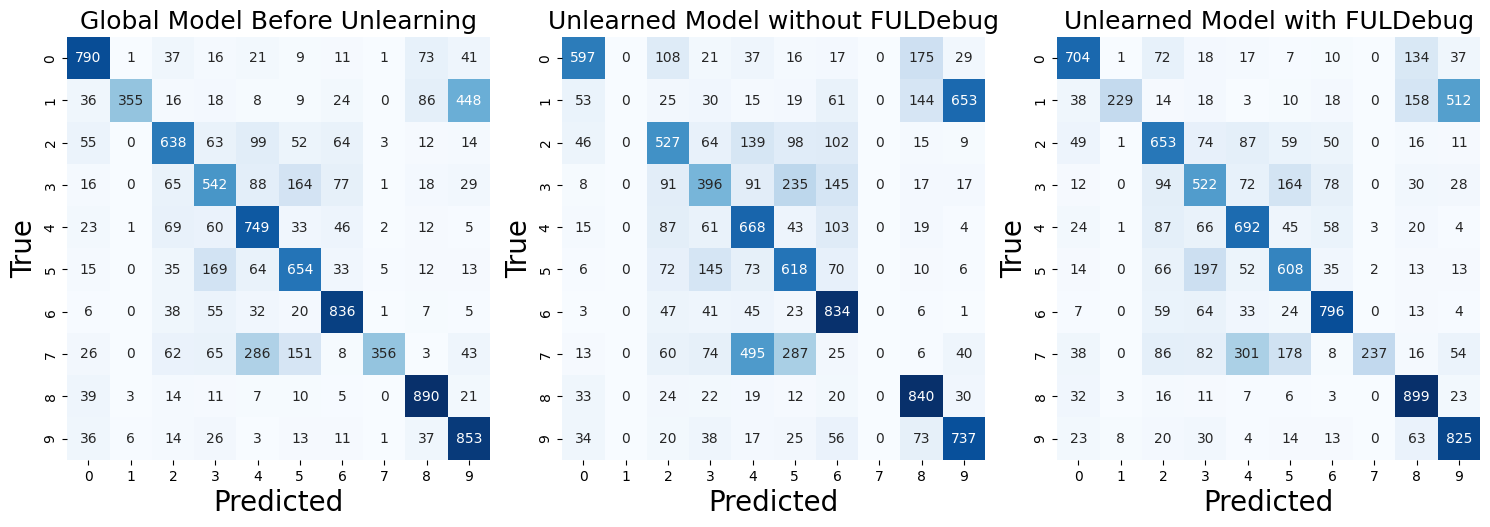

In [51]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# Assume these models are retrieved from your cache as in your snippet:
unlearned_model = cache.get('initial_model')
unlearned_model.load_state_dict(cache.get("unlearning_global_models"))
unlearned_model.eval()

unlearned_model_with_fuldebug = cache.get('initial_model')
unlearned_model_with_fuldebug.load_state_dict(cache.get("unlearning_global_models_with_FULDebug"))
unlearned_model_with_fuldebug.eval()

global_model_before = cache.get('initial_model')
global_model_before.load_state_dict(cache.get("global_models"))
global_model_before.eval()

client_model = cache.get('initial_model')
client_model.load_state_dict(cache.get("client_models")[0].state_dict())
client_model.eval()

# Prepare the test dataset (MNIST)
# transform = transforms.Compose([transforms.ToTensor()])
# test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = testDataloader

def evaluate_model(model, dataloader, device='cpu'):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            # Case 1: If images are 5D and second dimension is 1, remove the extra dimension.
            if images.dim() == 5 and images.size(1) == 1:
                images = images.squeeze(1)  # New shape: [N, 1, H, W]
            # Case 2: If images are 4D and the last dimension equals 3,
            # but the channel dimension is not in position 1 (i.e. channels-last format),
            # then permute to convert them to [N, 3, H, W].
            if images.dim() == 4 and images.size(-1) == 3 and images.size(1) != 3:
                images = images.permute(0, 3, 1, 2)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)


device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Evaluate each model on the test dataset
labels_global, preds_global = evaluate_model(global_model_before, test_loader, device)
labels_unlearned, preds_unlearned = evaluate_model(unlearned_model, test_loader, device)
labels_unlearned_with_fuldebug, preds_unlearned_with_fuldebug = evaluate_model(unlearned_model_with_fuldebug, test_loader, device)
labels_client, preds_client = evaluate_model(client_model, test_loader, device)

# Calculate confusion matrices and accuracies
cm_global = confusion_matrix(labels_global, preds_global)
cm_unlearned_without_fuldebug = confusion_matrix(labels_unlearned, preds_unlearned)
cm_unlearned_with_fuldebug = confusion_matrix(labels_unlearned_with_fuldebug, preds_unlearned_with_fuldebug)
cm_client = confusion_matrix(labels_client, preds_client)

acc_global = accuracy_score(labels_global, preds_global)
acc_unlearned = accuracy_score(labels_unlearned, preds_unlearned)
acc_unlearned_with_fuldebug = accuracy_score(labels_unlearned_with_fuldebug, preds_unlearned_with_fuldebug)
acc_client = accuracy_score(labels_client, preds_client)

print(f"Global Model Before Unlearning Accuracy: {acc_global*100:.2f}%")
print(f"Unlearned Model Accuracy: {acc_unlearned*100:.2f}%")
print(f"Unlearned Model Accuracy with FulDebug: {acc_unlearned_with_fuldebug*100:.2f}%")
print(f"Client Model Accuracy: {acc_client*100:.2f}%")

# Plot confusion matrices side by side in equal-size subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Global Model Before Unlearning
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues', ax=axes[0], square=True, cbar=False)
axes[0].set_title(f'Global Model Before Unlearning', fontsize=18)
axes[0].set_xlabel('Predicted', fontsize=20)
axes[0].set_ylabel('True', fontsize=20)

# Unlearned Model without FULDebug
sns.heatmap(cm_unlearned_without_fuldebug, annot=True, fmt='d', cmap='Blues', ax=axes[1], square=True, cbar=False)
axes[1].set_title(f'Unlearned Model without FULDebug', fontsize=18)
axes[1].set_xlabel('Predicted', fontsize=20)
axes[1].set_ylabel('True', fontsize=20)

# Unlearned Model with FULDebug
sns.heatmap(cm_unlearned_with_fuldebug, annot=True, fmt='d', cmap='Blues', ax=axes[2], square=True, cbar=False)
axes[2].set_title(f'Unlearned Model with FULDebug', fontsize=18)
axes[2].set_xlabel('Predicted', fontsize=20)
axes[2].set_ylabel('True', fontsize=20)

# Client Model
# sns.heatmap(cm_client, annot=True, fmt='d', cmap='Blues', ax=axes[3], square=True, cbar=False)
# axes[3].set_title(f'Unlearned Client Model', fontsize=18)
# axes[3].set_xlabel('Predicted', fontsize=20)
# axes[3].set_ylabel('True', fontsize=20)

plt.tight_layout()
plt.savefig('cifar10-10-federaser')
plt.show()
